# Milestone 1

## Download the data

The data used for this project is taken from the `brise-plandok` project on [github](https://github.com/recski/brise-plandok). It is already separated in a test, train and validation set. The following python script can also be executed from command line using python `python download.py` in the `data` directory.

In [1]:
import requests

csv_urls = [
    "https://raw.githubusercontent.com/recski/brise-plandok/main/brise_plandok/baselines/input/test_data.csv",
    "https://raw.githubusercontent.com/recski/brise-plandok/main/brise_plandok/baselines/input/train_data.csv",
    "https://raw.githubusercontent.com/recski/brise-plandok/main/brise_plandok/baselines/input/valid_data.csv"
]
for url in csv_urls:
    r = requests.get(url, allow_redirects=True)
    set = url.split("/")[-1].split("_")[0]
    open(f'../data/{set}_data.csv', 'wb').write(r.content)

## Preprocessing

### Setup for preprocessing

In [2]:
import nltk
import stanza
import pandas as pd
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from data.constants import ALL_LABELS_SORTED

In [3]:
nltk.download('stopwords')
german_stop_words = nltk.corpus.stopwords.words('german')
stanza.download('de')
nlp=stanza.Pipeline(processors="tokenize,mwt,lemma", lang="de",use_gpu=True)

[nltk_data] Downloading package stopwords to /home/aq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2022-11-10 13:48:09 INFO: Downloading default packages for language: de (German) ...
2022-11-10 13:48:10 INFO: File exists: /home/aq/stanza_resources/de/default.zip
2022-11-10 13:48:17 INFO: Finished downloading models and saved to /home/aq/stanza_resources.
2022-11-10 13:48:17 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-11-10 13:48:17 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| lemma     | gsd     |

2022-11-10 13:48:17 INFO: Use device: cpu
2022-11-10 13:48:17 INFO: Loading: tokenize
2022-11-10 13:48:17 INFO: Loading: mwt
2022-11-10 13:48:17 INFO: Loading: lemma
2022-11-10 13:48:17 INFO: Done loading processors!


In [4]:
# Path to csv files
WD = '../'
data_path = WD + 'data/'
train_df = pd.read_csv(data_path + 'train_data.csv')
valid_df = pd.read_csv(data_path + 'valid_data.csv')
test_df = pd.read_csv(data_path + 'test_data.csv')

In [5]:
def tokenize(input: str):
    doc = nlp(input)
    return [word.lemma  for sent in doc.sentences for word in sent.words if word.lemma not in german_stop_words]

def preprocess_features(df: pd.DataFrame, type_of_data: str, vocab=None):
    vectorizer = CountVectorizer(tokenizer=tokenize, vocabulary=vocab, lowercase=False)
    features = df.iloc[:, [0, 1]].copy()
    vectors = vectorizer.fit_transform(features.Text).toarray()
    transformed_features = pd.DataFrame(vectors, columns=vectorizer.get_feature_names_out())
    features=features.join(transformed_features)
    features.to_csv((data_path+type_of_data + '_features.csv'), index=False)
    return features.columns[2:].tolist()

def preprocess_labels(df: pd.DataFrame, type_of_data: str):
    labels =  df.iloc[:, [0, 2]].copy()
    labels.Labels = labels.Labels.apply(ast.literal_eval)
    mlb = MultiLabelBinarizer(classes=list(ALL_LABELS_SORTED.keys()))
    labels_transformed = mlb.fit_transform(labels['Labels'])
    labels[mlb.classes_] = labels_transformed
    labels.to_csv((data_path + type_of_data + '_labels.csv'), index=False)

def preprocess_df(df: pd.DataFrame, type_of_data: str, vocab=None):
    vocab = preprocess_features(df, type_of_data, vocab)
    preprocess_labels(df, type_of_data)
    return vocab

### Run preprocessing

The following code extracts features and labels as new csv files from the original files `test_data.csv`, `train_data.csv` and `valid_data.csv`. The newly constructed csv files will be used for our model.

In [7]:
%%time
vocab = preprocess_df(train_df, 'train')
preprocess_df(valid_df, 'valid', vocab)
preprocess_df(test_df, 'test', vocab)

CPU times: user 9min 21s, sys: 22 s, total: 9min 43s
Wall time: 2min 26s


['!',
 '"',
 '%',
 "'",
 "'bestimmen",
 '(',
 ')',
 '*',
 '+',
 '+100,0',
 '+130-180',
 '+130-190',
 '+170-190',
 '+43,0',
 '+43m',
 '+45',
 '+56m',
 '+8,00',
 '+82,0',
 ',',
 ',5',
 '-',
 '-...-k6-(',
 '-alber',
 '-berg-straße',
 '-bormann',
 '-bronner-straße',
 '-buol',
 '-buol-',
 '-buol-gasse',
 '-collin-straße',
 '-der',
 '-ferstl-gasse',
 '-flur-gasse',
 '-fröhlich',
 '-gart',
 '-gaß',
 '-gestalt',
 '-gestaltend',
 '-graßel',
 '-gunther',
 '-hannak-gasse',
 '-harell',
 '-hauer',
 '-heindl',
 '-höhnel',
 '-jonas-platz',
 '-jurmann',
 '-karl-straße',
 '-karlgasse',
 '-karlstraße',
 '-kittenberger',
 '-koci-straße',
 '-konstruktionsoberkante',
 '-kram',
 '-kramer-straße',
 '-kutscha-',
 '-laaer-straße',
 '-laar',
 '-lefler',
 '-leinkauf-platz',
 '-loos',
 '-ludwig',
 '-marx-straße',
 '-maxa',
 '-mosesgasse',
 '-nepomuk',
 '-nordos1',
 '-nordost',
 '-nüll',
 '-padaurek',
 '-padaurek-straße',
 '-park',
 '-platz',
 '-popper-straße',
 '-pöch',
 '-raschke',
 '-redlich',
 '-reim',
 '-rest

## Training

For this exercise, we chose to train a random forest classifier and a multi-layer perceptron classifier.

### Setup for training

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

In [9]:
df_features = pd.read_csv(data_path + 'train_features.csv')
df_labels = pd.read_csv(data_path + 'train_labels.csv')
valid_features = pd.read_csv(data_path + 'valid_features.csv')
valid_labels = pd.read_csv(data_path + 'valid_labels.csv')

In [10]:
y_train = df_labels.iloc[:, 2:].copy()
x_train = df_features.iloc[:, 2:].copy()
y_test = valid_labels.iloc[:, 2:].copy()
x_test = valid_features.iloc[:, 2:].copy()

In [48]:
classifier_rf = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
classifier_deep = MLPClassifier(random_state=1, max_iter=290)

## Perform training

In [50]:
%%time
classifier_rf.fit(x_train, y_train)
classifier_deep.fit(x_train, y_train)

CPU times: user 12min 58s, sys: 27.4 s, total: 13min 25s
Wall time: 3min 33s


MLPClassifier(max_iter=290, random_state=1)

## Evaluation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

In [51]:
y_pred_rf = classifier_rf.predict(x_test)
y_pred_deep = classifier_deep.predict(x_test)

In [52]:
report_rf=metrics.classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
report_deep=metrics.classification_report(y_test, y_pred_deep, output_dict=True, zero_division=0)

### Metrics for multi-label classification

We have unbalanced classes, so accuracy is not a good metric. Better precision, recall, f1-score etc. For each class, we can compute the usual metrics for binary classification and the confusion matrix. Aggregated metrics like macro, micro, weighted and sampled avg give us a high-level view of how our model is performing.

- <b>Macro Average</b>
This is simply the average of a metric — precision, recall or f1-score — over all classes.

- <b>Micro Average</b>
The micro-average of a metric is calculated by considering all the TP, TN, FP and FN for each class, adding them up and then using those to compute the metric’s micro-average

- <b>Weighted Average</b>
This is simply the average of the metric values for individual classes weighted by the support of that class. The support is how many times a class appeared in y_test.

- <b>Samples Average</b>
Here, we compute metrics for each sample and then average them.

In [53]:
macros=['micro avg','macro avg','weighted avg','samples avg']
scores=['precision','recall','f1-score']
df = pd.DataFrame(columns=['model','measure','value'])

for macro in macros:
    for score in scores:
        df.loc[len(df)] = ['rf',macro+'-'+score, report_rf[macro][score]]
        df.loc[len(df)] = ['deep',macro+'-'+score, report_deep[macro][score]]

display(df)

,model,measure,value
0,rf,micro avg-precision,0.949807
1,deep,micro avg-precision,0.919878
2,rf,micro avg-recall,0.693609
3,deep,micro avg-recall,0.852444
4,rf,micro avg-f1-score,0.801738
5,deep,micro avg-f1-score,0.884878
6,rf,macro avg-precision,0.607036
7,deep,macro avg-precision,0.677706
8,rf,macro avg-recall,0.447390
9,deep,macro avg-recall,0.620751


The above table demonstrates the performance of ours classifiers. We can see that - in most cases - the multi-layer perceptron classifier yields better results than the random forest classifier. This property is visualized in the following plot.

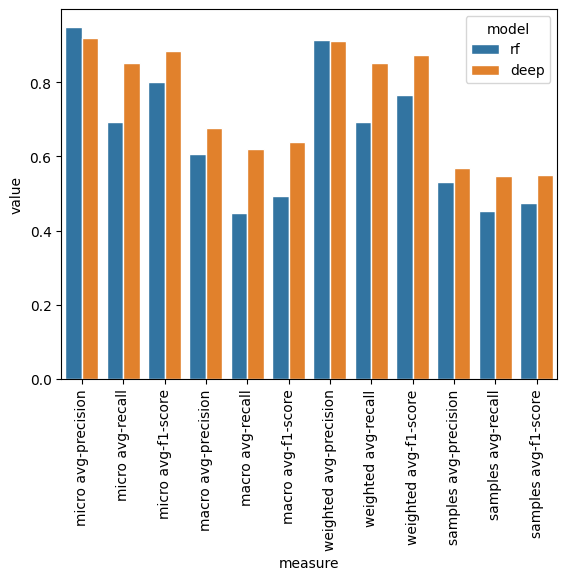

In [54]:
sns.barplot(x='measure', y='value', hue='model', data=df,
            palette='tab10', edgecolor='w')
plt.xticks(rotation=90)
plt.show()

In [73]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

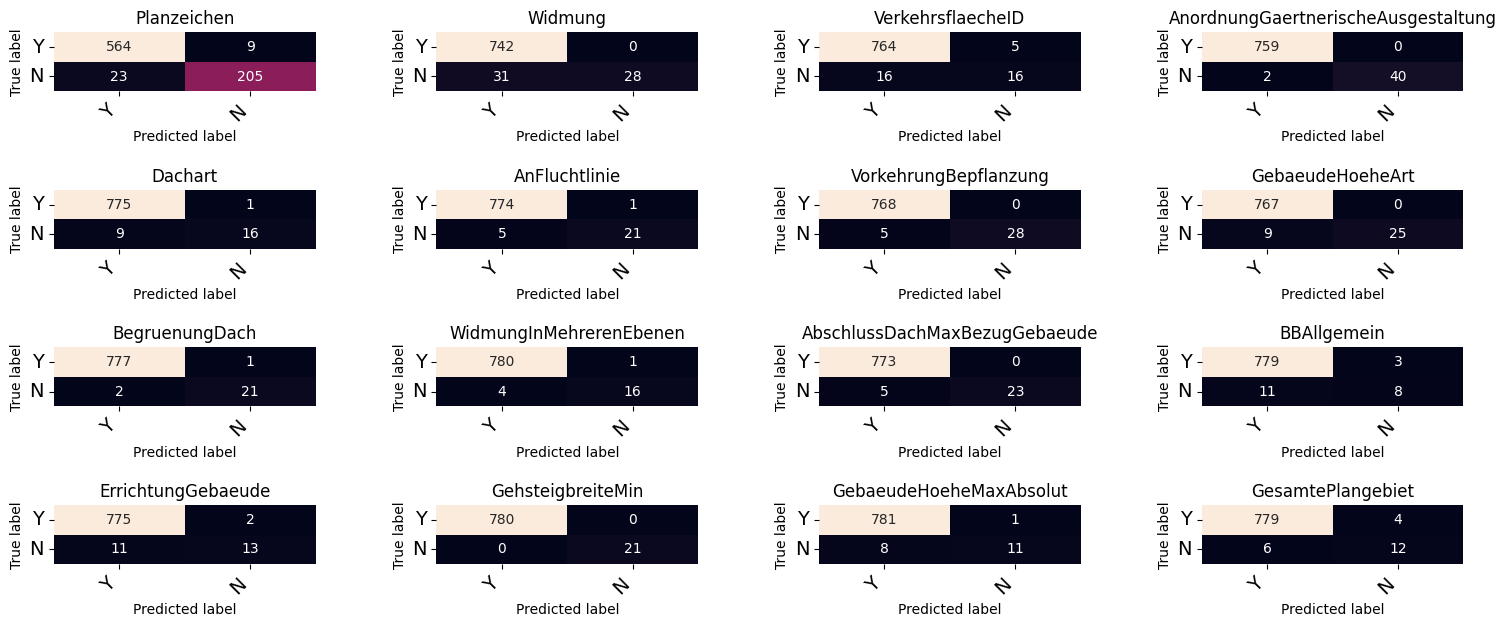

In [74]:
vis_arr = multilabel_confusion_matrix(y_test, y_pred_rf)
labels =  y_test.columns
fig, ax = plt.subplots(4, 4, figsize=(16, 7))
fig.tight_layout(pad=5.0)

for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])

plt.show()